In [2]:
# Import libraries here
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")


def wrangle(collection):
    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},   # ---> focus/ limit to only "P2" and timestamp
    )

    df = pd.DataFrame(results).set_index("timestamp")
    
    # Localize time
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
    
    # Remove outliers
    df = df[df["P2"] < 100]
    
    # Resample to 1hour period, fill in missing values
    y = df["P2"].resample("1H").mean().fillna(method='ffill')
    
    return y
  



In [15]:


df = pd.read_csv("dar_es_salaam_wrangled.csv", parse_dates=['timestamp'])

# Set 'timestamp' as the index
df.set_index('timestamp', inplace=True)

# If your PM2.5 values are in column 'P2' (or rename accordingly)
y = df['P2']

# Now y is a pandas Series indexed by datetime
print(y.head())
print(y.index)  # Should show a DatetimeIndex

timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Name: P2, dtype: float64
DatetimeIndex(['2018-01-01 03:00:00+03:00', '2018-01-01 04:00:00+03:00',
               '2018-01-01 05:00:00+03:00', '2018-01-01 06:00:00+03:00',
               '2018-01-01 07:00:00+03:00', '2018-01-01 08:00:00+03:00',
               '2018-01-01 09:00:00+03:00', '2018-01-01 10:00:00+03:00',
               '2018-01-01 11:00:00+03:00', '2018-01-01 12:00:00+03:00',
               ...
               '2018-03-31 17:00:00+03:00', '2018-03-31 18:00:00+03:00',
               '2018-03-31 19:00:00+03:00', '2018-03-31 20:00:00+03:00',
               '2018-03-31 21:00:00+03:00', '2018-03-31 22:00:00+03:00',
               '2018-03-31 23:00:00+03:00', '2018-04-01 00:00:00+03:00',
               '2018-04-01 01:00:00+03:00', '2018-04-01 02:00:00+03:00'],
              dtype='date

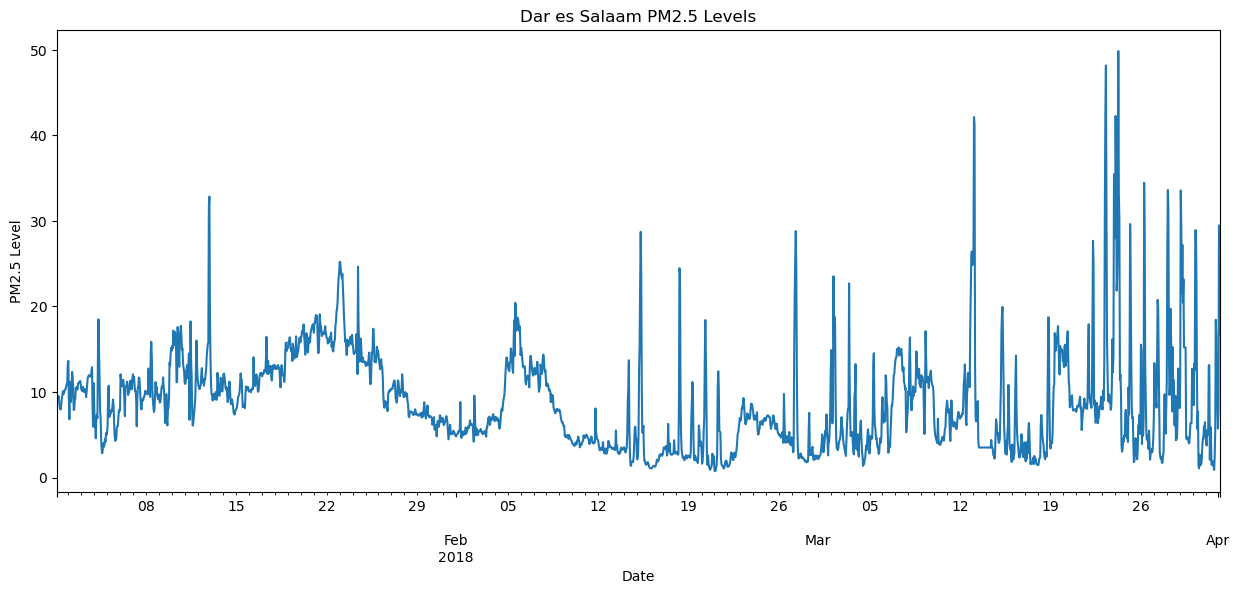

In [16]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels", ax=ax);


# use ax=ax in your plot


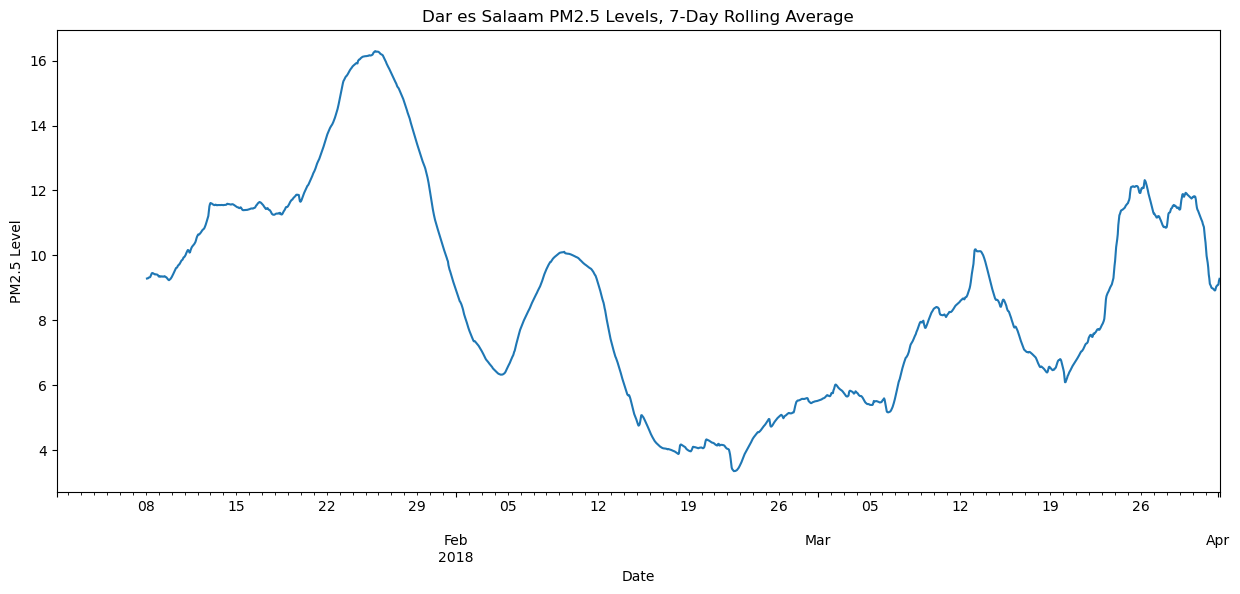

In [17]:

fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average");
# --> 168 == num of hours in a week



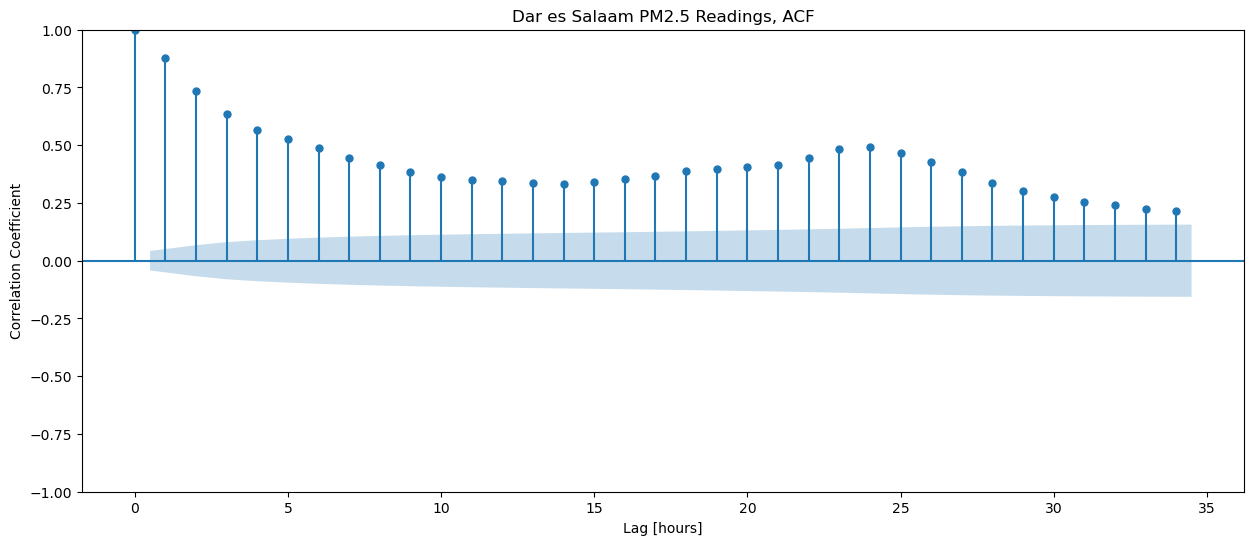

In [18]:

# use ax=ax in your plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]"
          )
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");



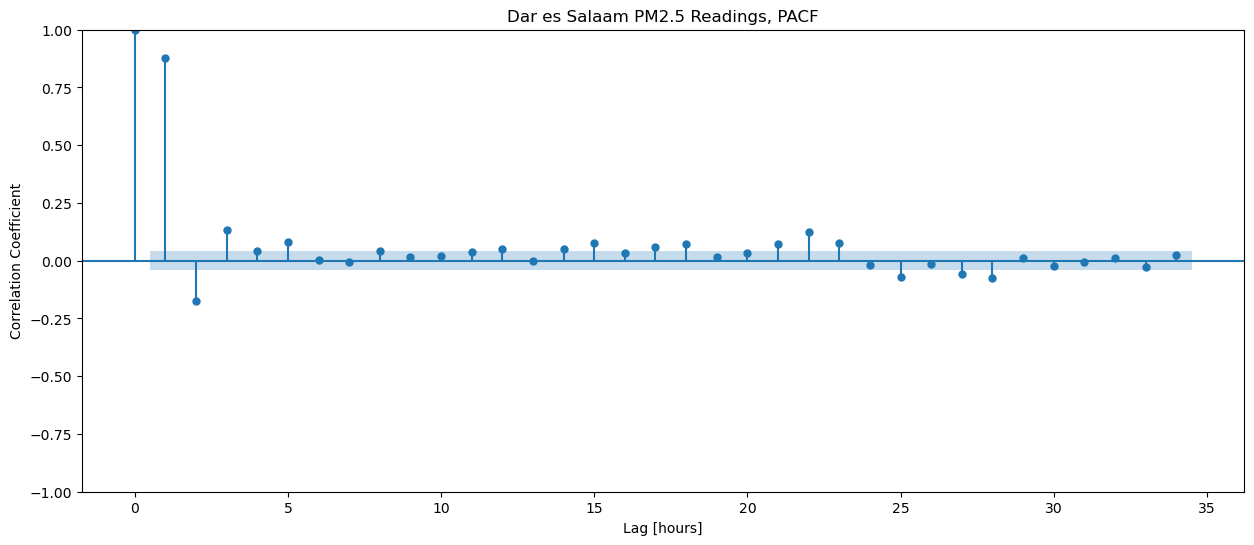

In [19]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)  
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF");

In [ ]:
#splitting 90,10
cutoff_test = int(0.90*len(y))
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)


In [21]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)



Mean P2 Reading: 8.57142319061077
Baseline MAE: 4.053101181299159


In [22]:
 #Hyperparameter --> p
p_params = range(1, 31)
maes = []
for p in p_params:
    #Train model
    model = AutoReg(y_train, lags=p).fit()
    
    #Generate in-sample pred
    y_pred = model.predict().dropna()
        
    #Calculate mae
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(mae)
    
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

# Inspect head of Series
mae_series.head()

1    1.059376
2    1.045182
3    1.032489
4    1.032147
5    1.031022
Name: mae, dtype: float64

In [23]:

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

mae_series    # locate best_p
best_p = 26

# build and train model
best_model = AutoReg(y_train, lags=best_p).fit()

# calculate training residuals for best_model


In [24]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 05:00:00+03:00   -0.412913
2018-01-02 06:00:00+03:00    1.484934
2018-01-02 07:00:00+03:00    1.672359
2018-01-02 08:00:00+03:00   -0.368030
2018-01-02 09:00:00+03:00   -0.536868
Name: residuals, dtype: float64

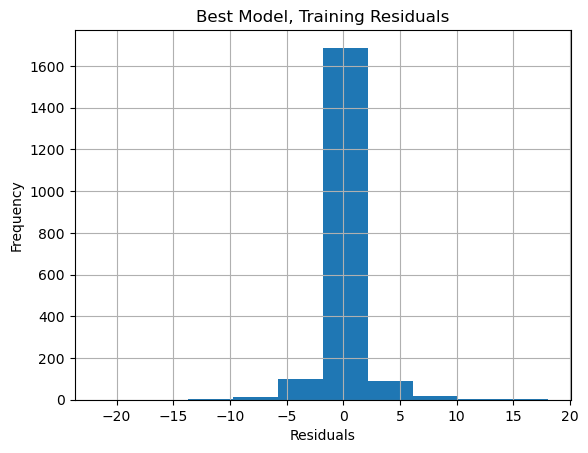

In [25]:
# Plot histogram of residuals
fig, ax = plt.subplots(figsize=(6.4, 4.8))

y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");
# Use ax=ax in your plot


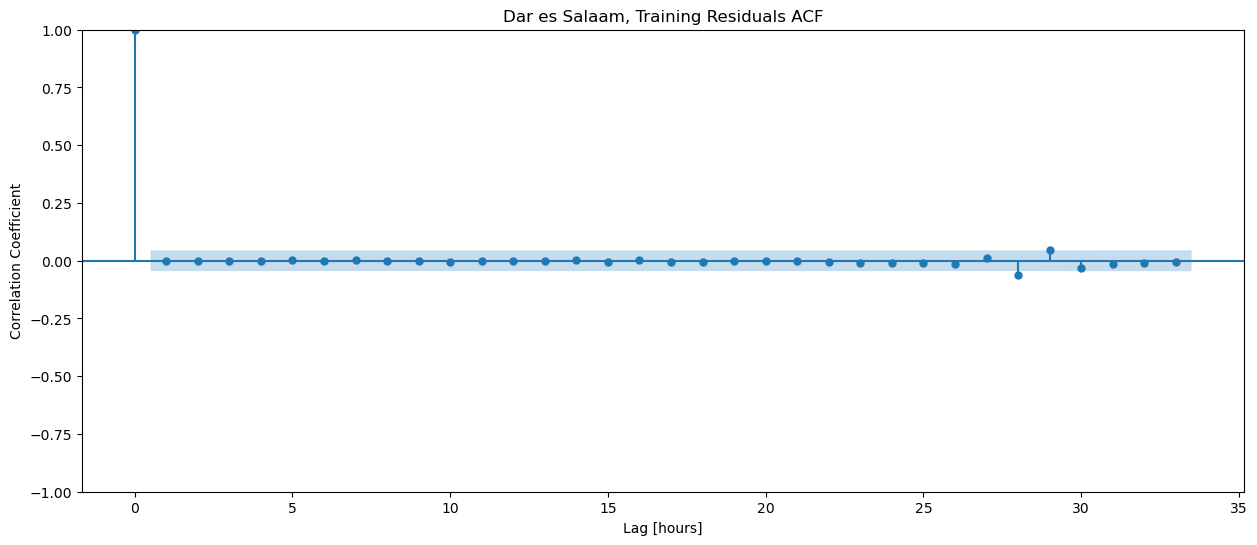

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
# Use ax=ax in your plot

plt.xlabel("Lag [hours]"
          )
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam, Training Residuals ACF");




In [30]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

y_pred_wfv = pd.Series(dtype=float)  # empty Series with float dtype
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()  # Series with 1 value
    
    # Append prediction
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    
    # Append actual observation to history
    history = pd.concat([history, y_test.iloc[i:i+1]])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"

print(y_pred_wfv.head())


timestamp
2018-03-23 03:00:00+03:00    10.414744
2018-03-23 04:00:00+03:00     8.269589
2018-03-23 05:00:00+03:00    15.178677
2018-03-23 06:00:00+03:00    33.475398
2018-03-23 07:00:00+03:00    39.571363
Freq: h, Name: prediction, dtype: float64


In [31]:
# Enter y_pred_wfv at ... (Ellipsis) to see the test mean absolute error

test_mae = mean_absolute_error(y_test,y_pred_wfv )
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.97


In [32]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}
)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})

fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)